In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import np_utils
from imgaug import augmenters as iaa    
import itertools
from tqdm import tqdm

Using TensorFlow backend.


### Test classification model

In [2]:
# Print version
print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# Get compute specs
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

print(get_available_gpus())

Keras Version 2.3.0
Tensorflow Version 1.14.0
[]


In [3]:
# Focal loss function
##################################################################################
# Paper: https://arxiv.org/abs/1708.02002

#Focal loss down-weights the well-classified examples. This has
#the net effect of putting more training emphasis on that data that is hard to classify. 
#In a practical setting where we have a data imbalance, our majority class will quickly 
#become well-classified since we have much more data for it. Thus, in order to insure that we
#also achieve high accuracy on our minority class, we can use the focal loss to give those minority
#class examples more relative weight during training. 

from keras import backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# loss=[focal_loss(alpha=.25, gamma=2)]
##################################################################################



# Helpers
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

def plot_hist(img):
    
    img_flat = img.flatten()
    print(min(img_flat), max(img_flat))
    
    plt.hist(img_flat, bins=20, color='c')
    #plt.title("Data distribution")
    plt.xlabel("Pixel values")
    plt.grid(True)
    plt.ylabel("Frequency")
    
    plt.show()
    
    

# Define paths
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')
PATH = "{}/{}".format(DATASET, "isic2016numpy")
OUTPUTS = "{}/{}".format(ROOT_DIR, "outputs")
MODEL_PATH = os.path.join(ROOT_DIR, "models")
print(PATH)

/home/hasib/lesion-learnt/dataset/isic2016numpy


In [4]:
# load data
x_test = np.load("{}/x_test.npy".format(PATH))
y_test = np.load("{}/y_test.npy".format(PATH))
x_test.shape, y_test.shape

((379, 256, 256, 3), (379, 2))

### Load classification model

In [5]:
EXP_NAME = "1_vgg_baseline"

# Create folder for each experiment
create_directory("{}/{}".format(OUTPUTS, EXP_NAME))
output_path = os.path.join(OUTPUTS, EXP_NAME)
output_path

'/home/hasib/lesion-learnt/outputs/1_vgg_baseline'

In [6]:
model = load_model(os.path.join(MODEL_PATH, '1_vgg_baseline.h5'), compile=False) #custom_objects={'focal_loss_fixed':focal_loss()}
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [7]:
# Define dictionary for storing results 
report = {}

# Convert ground truth to column values
y_test_flat = np.argmax(y_test, axis=1)
print(y_test_flat.shape)

(379,)


In [8]:
y_pred = []

# Make predictions using trained model
for x in tqdm(x_test[:]):
    inp = np.expand_dims(x, axis=0)
    pred = model.predict(inp)
    y_pred.append(pred[0])
    #print(pred)

y_pred = np.array(y_pred)
y_pred.shape

  0%|          | 0/379 [00:00<?, ?it/s]

100%|██████████| 379/379 [03:58<00:00,  1.75it/s]


(379, 2)

In [18]:
# Get labels from predictions
y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) # y_pred[1] -> probability for class 1 
print(y_pred.shape, y_pred_flat.shape)

(379, 2) (379,)


In [19]:
y_pred_flat.shape

(379,)

In [20]:
# Accuracy
acc = accuracy_score(y_test_flat, y_pred_flat) * 100
report["Test accuracy"] = acc
print("Accuracy :", acc)


# Average precision
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, y_pred) * 100
report["Average precision"] = ap
print("Average precision :", ap)


# All metrics report
confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)

target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

cm = confusion_matrix(y_pred=y_pred_flat, y_true=y_test_flat)
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
report["Sensitivity"] = sensitivity*100
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
report["Specificity"] = Specificity*100
print('Specificity : ', Specificity*100 )

Accuracy : 35.35620052770449
Average precision : 58.850969278838214
[[ 64 240]
 [  5  70]]
              precision    recall  f1-score   support

           0       0.93      0.21      0.34       304
           1       0.23      0.93      0.36        75

    accuracy                           0.35       379
   macro avg       0.58      0.57      0.35       379
weighted avg       0.79      0.35      0.35       379

Sensitivity :  92.7536231884058
Specificity :  22.58064516129032


AUC : 0.5719298245614035


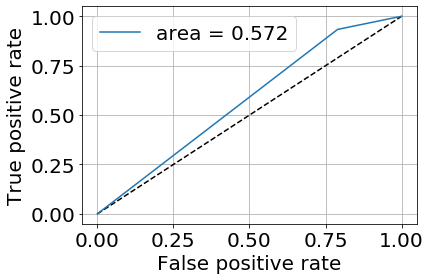

In [21]:
# Area under curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test_flat, y_pred_flat)
auc = metrics.auc(fpr, tpr)
report["Area Under ROC curve"] = metrics.auc(fpr, tpr)
print("AUC :", auc)

# plot area under ROC curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_flat, y_pred_flat)
#auc_sc = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.grid(True)
#plt.savefig('{}/{}_roc.jpg'.format(output_path, EXP_NAME), dpi=100)
plt.savefig('{}/{}_roc.pdf'.format(output_path, EXP_NAME), dpi=300)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.59')

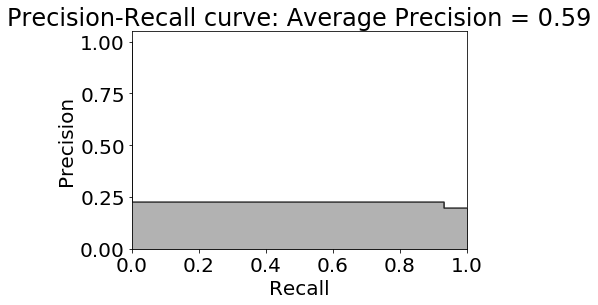

In [22]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_flat,y_pred_flat)
average_precision = average_precision_score(y_test,y_pred)
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

In [23]:

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

labels = ['0', '1']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('{}/{}_cf.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.figure(figsize=(8,8))
    plt.show()

# plot fancy image
#plot_confusion_matrix(cm, classes=labels,title='Confusion Matrix')

Confusion matrix, without normalization
[[ 64 240]
 [  5  70]]


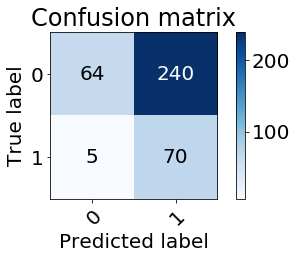

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


# plot confusion matrix only
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig('{}/{}_cm.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.savefig('{}/{}_cm.pdf'.format(output_path, EXP_NAME), dpi=300)
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_flat, y_pred_flat, classes=np.array([0, 1]), title='Confusion matrix')
plt.show()

In [25]:
# save metric report
print(report)

{'Test accuracy': 35.35620052770449, 'Average precision': 58.850969278838214, 'Sensitivity': 92.7536231884058, 'Specificity': 22.58064516129032, 'Area Under ROC curve': 0.5719298245614035}


In [26]:
with open("{}/{}_report.json".format(output_path, EXP_NAME), 'w') as f:
    for k,v in report.items():
        f.write(str(k))
        f.write("--->")
        f.write(str(v))
        # new line
        f.write("\n")
f.close()